In [6]:
import numpy as np
import torch
from torch import nn
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter

from config import device, grad_clip, print_freq, pretrained_model_path
from data_gen import ArcFaceDataset
from focal_loss import FocalLoss
from lfw_eval import lfw_test

import random


import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [11]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [201]:
class Config():
    training_dir = "/home/ahmadob/dataset/facerecognition_dataset/train_face_set"
    testing_dir = "/home/ahmadob/dataset/facerecognition_dataset/test_face_set"
    train_batch_size = 256
    train_number_epochs = 100

In [202]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.125, contrast=0.125, saturation=0.125),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [203]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self, imageFolderDataset, transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self, index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
#         print(img0_tuple)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0]).convert('RGB')
        img1 = Image.open(img1_tuple[0]).convert('RGB')


        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1] == img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [204]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset = folder_dataset, transform = data_transforms['train'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


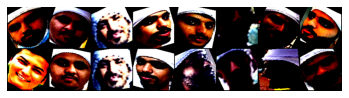

[[0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]]


In [206]:
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers = 8, batch_size = 8)

dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [207]:
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        checkpoint = 'BEST_checkpoint.tar' # mobile facenet trained backbone
        checkpoint = torch.load(checkpoint)
        
        
        self.backbone = checkpoint['model'].module
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        self.fc_classifier = nn.Sequential(
            nn.Linear(256, 32), # 1 hidden layer with 32 neurons
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward_once(self, x):
        output = self.backbone(x)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output = torch.cat((output1, output2), 1)
        output = self.fc_classifier(output)
        return output

In [208]:
net = SiameseNetwork().cuda()

In [209]:
net

SiameseNetwork(
  (backbone): MobileFaceNet(
    (conv1): ConvBNReLU(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (dw_conv): DepthwiseSeparableConv(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (pointwise): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2): ConvBNReLU(
      (0): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (gdconv): GDConv(
      (depthwise): Con

In [210]:
from torchsummary import summary

In [211]:
summary(net, [(3, 112, 112), (3, 112, 112)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           1,728
       BatchNorm2d-2           [-1, 64, 56, 56]             128
             ReLU6-3           [-1, 64, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]             576
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]           4,096
       BatchNorm2d-8           [-1, 64, 56, 56]             128
              ReLU-9           [-1, 64, 56, 56]               0
DepthwiseSeparableConv-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 128, 56, 56]           8,192
      BatchNorm2d-12          [-1, 128, 56, 56]             256
            ReLU6-13          [-1, 128, 56, 56]               0
           Conv2d-14          [-1,

In [212]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam([{'params': net.fc_classifier.parameters()}], lr = 0.001)

In [213]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [214]:
train_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8, batch_size=Config.train_batch_size)

Epoch number 0
 Current loss 0.7070014476776123

Epoch number 1
 Current loss 0.6777983903884888

Epoch number 2
 Current loss 0.6528769731521606

Epoch number 3
 Current loss 0.6265178918838501

Epoch number 4
 Current loss 0.6149808764457703

Epoch number 5
 Current loss 0.5898204445838928

Epoch number 6
 Current loss 0.5457664728164673

Epoch number 7
 Current loss 0.5270094871520996

Epoch number 8
 Current loss 0.497958779335022

Epoch number 9
 Current loss 0.4559471607208252

Epoch number 10
 Current loss 0.43476852774620056

Epoch number 11
 Current loss 0.41049954295158386

Epoch number 12
 Current loss 0.3743363618850708

Epoch number 13
 Current loss 0.37777045369148254

Epoch number 14
 Current loss 0.3371990919113159

Epoch number 15
 Current loss 0.29737386107444763

Epoch number 16
 Current loss 0.3366408348083496

Epoch number 17
 Current loss 0.30000150203704834

Epoch number 18
 Current loss 0.2929132282733917

Epoch number 19
 Current loss 0.260248064994812

Epoch n

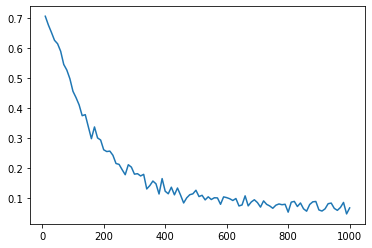

In [215]:
counter = []
loss_history = [] 
iteration_number = 0

for epoch in range(0, Config.train_number_epochs):
    for i, data in enumerate(train_dataloader, 0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output_prob = net(img0, img1)
        bce_loss = criterion(output_prob, label)
        bce_loss.backward()
        optimizer.step()
        if i % 10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch, bce_loss.item()))
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(bce_loss.item())
show_plot(counter, loss_history)

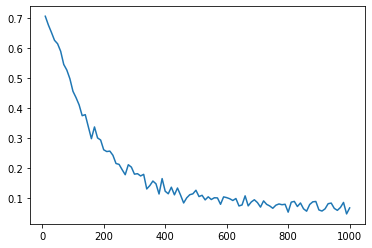

In [216]:
show_plot(counter, loss_history)

In [217]:
test_dataset = dset.ImageFolder(root=Config.testing_dir)
siamese_test_dataset = SiameseNetworkDataset(imageFolderDataset = test_dataset, transform = data_transforms['val'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


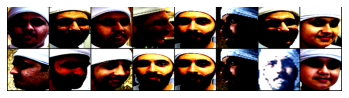

[[1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]]


In [218]:
vis_dataloader = DataLoader(siamese_test_dataset, shuffle=True, num_workers = 8, batch_size = 8)

dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [222]:
example_batch[0].shape

torch.Size([8, 3, 112, 112])

In [225]:
example_batch[1].shape

torch.Size([8, 3, 112, 112])

In [228]:
net.eval()
with torch.no_grad():
    test_img0, test_img1 = example_batch[0].cuda(), example_batch[1].cuda()
    pred_result = net(test_img0, test_img1)

In [231]:
for i in pred_result:
    if i < 0.5:
        print(0)
    else:
        print(1)

1
0
0
0
1
1
0
1
